Testing augmented_data_C01__01__F01.csv

Now, we will use an additional parameter in the Logistic Regression model where we indicate weight = "balanced" and with this the algorithm will be in charge of balancing the minority class during training

# Logistic Regression Classifier with balanced weights

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split

def print_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='Alive', yticklabels='Deceased', annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

(1256, 60)


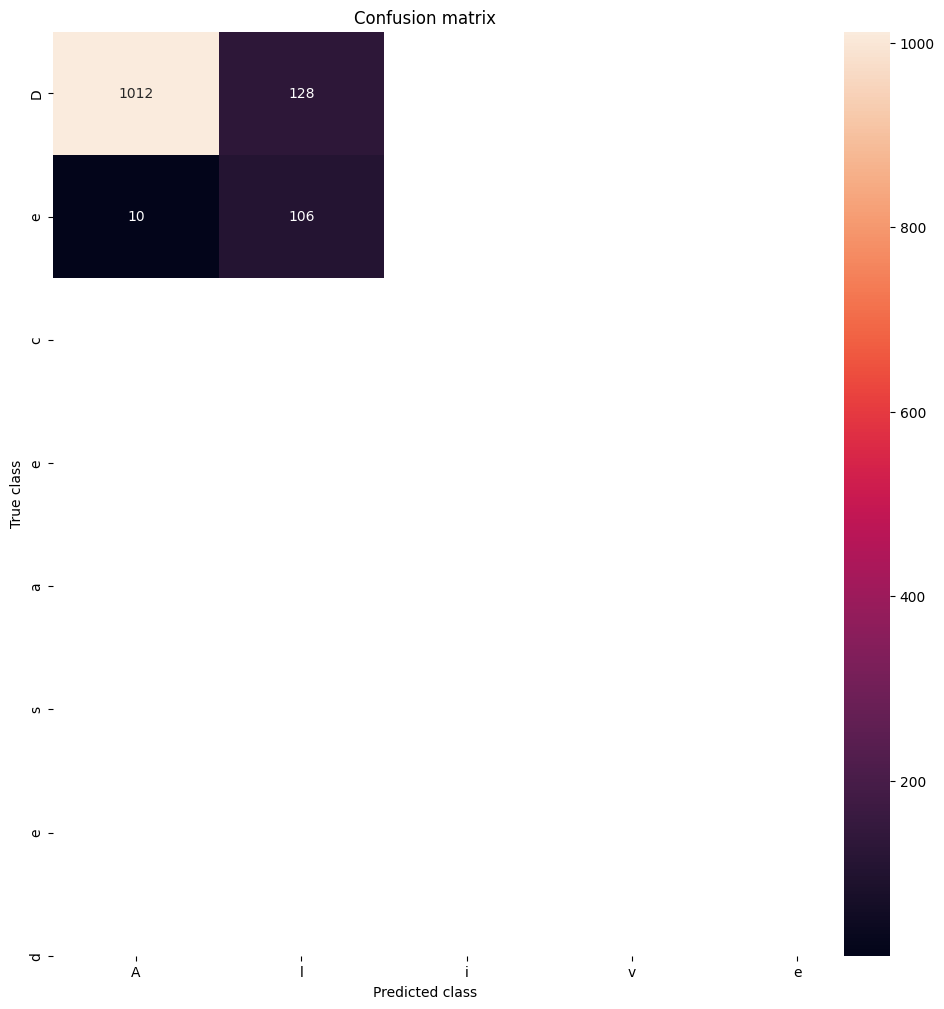

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      1140
         1.0       0.45      0.91      0.61       116

    accuracy                           0.89      1256
   macro avg       0.72      0.90      0.77      1256
weighted avg       0.94      0.89      0.91      1256



In [2]:

df_normalized = pd.read_csv('data_cleaned.csv') 
df_normalized= df_normalized.dropna()
print(df_normalized.shape)
X = df_normalized.drop('estado_vital', axis=1)
y = df_normalized['estado_vital']
# class wights
class_weight = {0: 1, 1: len(y) / sum(y)}
X_train=X
y_train=y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5) # 80% training and 20% test
df_normalized2=pd.read_csv('data_cleaned2.csv') 
X_test= df_normalized2.drop('estado_vital', axis=1)
y_test = df_normalized2['estado_vital']

def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf
 
model = run_model_balanced(X_train, X_test, y_train, y_test)
pred_y = model.predict(X_test)
print_results(y_test, pred_y)

Now we will use an algorithm to reduce the majority class. We will do it using an algorithm that is similar to k-nearest neighbor to select which ones to eliminate

# Subsampling in the majority class

Distribution before resampling Counter({0.0: 1140, 1.0: 116})
Distribution after resampling Counter({0.0: 116, 1.0: 116})


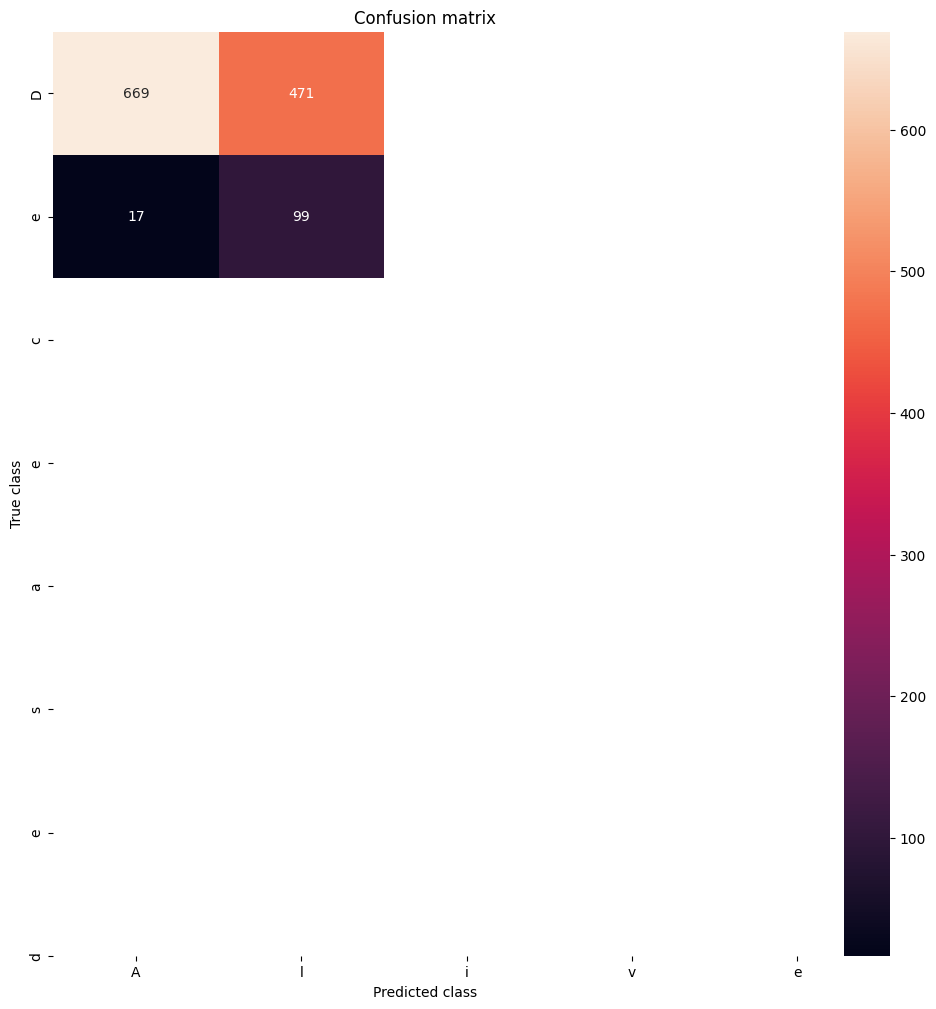

              precision    recall  f1-score   support

         0.0       0.98      0.59      0.73      1140
         1.0       0.17      0.85      0.29       116

    accuracy                           0.61      1256
   macro avg       0.57      0.72      0.51      1256
weighted avg       0.90      0.61      0.69      1256



In [3]:
from imblearn.under_sampling import NearMiss
from collections import Counter
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))
 
model = run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
print_results(y_test, pred_y)

We will create new “synthetic” samples of the minority class. Using RandomOverSampler

Now we will test a widely used technique that consists of simultaneously applying a subsampling algorithm and an oversampling algorithm to the dataset at the same time. In this case we will use SMOTE for oversampling: find nearby neighboring points and add points “in a straight line” between them. And we will use Tomek for undersampling that removes those of different classes that are nearest neighbors and lets us see better the decision boundary (the limit zone of our classes).

# Ensamble of models with BalancedBaggingClassifier

/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


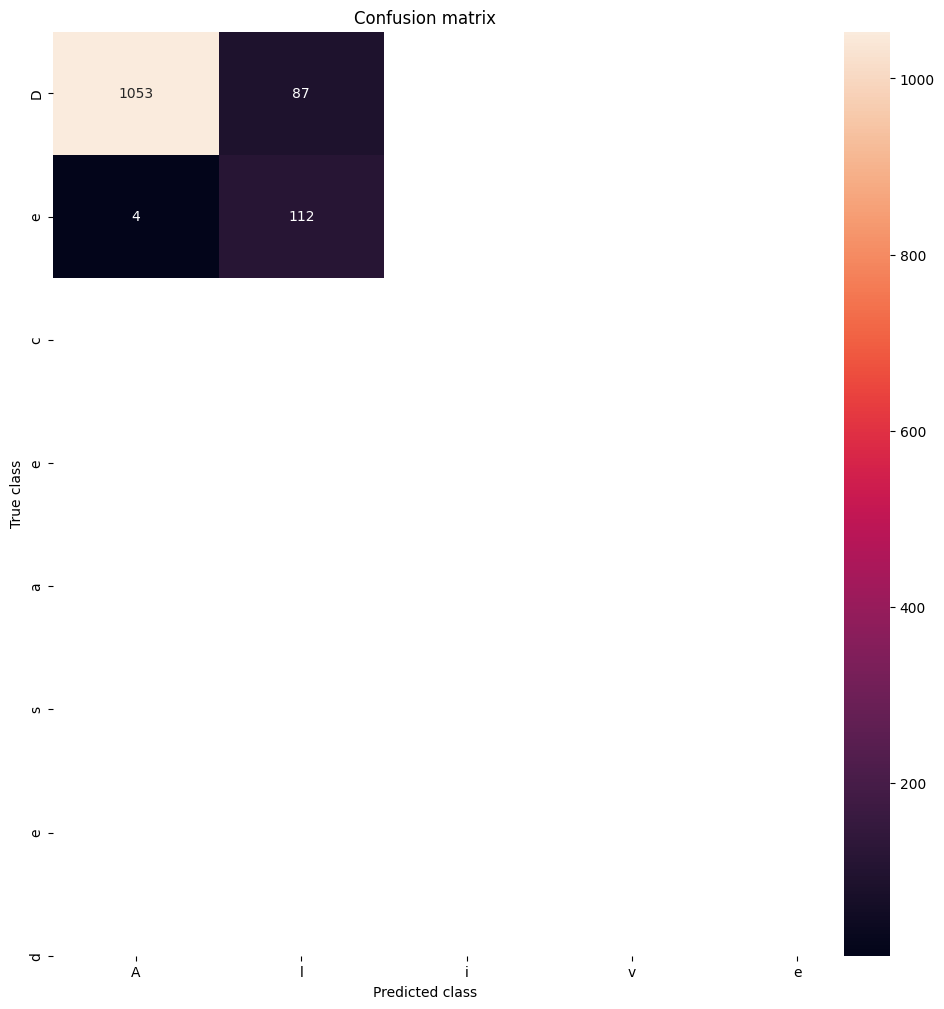

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1140
         1.0       0.56      0.97      0.71       116

    accuracy                           0.93      1256
   macro avg       0.78      0.94      0.83      1256
weighted avg       0.96      0.93      0.94      1256



In [4]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)
print_results(y_test, pred_y)

# SVM Classifier with balanced weights

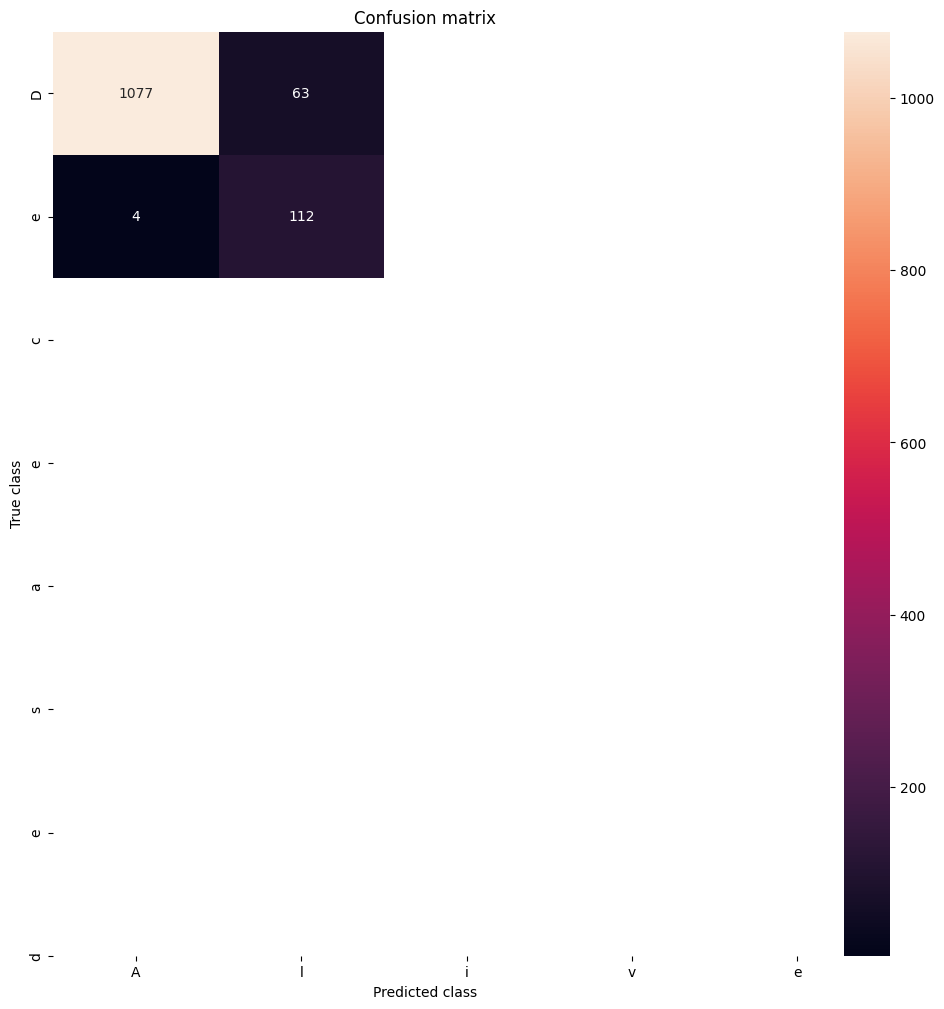

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1140
         1.0       0.64      0.97      0.77       116

    accuracy                           0.95      1256
   macro avg       0.82      0.96      0.87      1256
weighted avg       0.96      0.95      0.95      1256



In [5]:
from sklearn import svm

def run_svm_model(X_train, X_test, y_train, y_test):
    # create a svm classifier
    clf = svm.SVC(kernel='rbf',C=1.0,random_state=1,class_weight='balanced') # rbf kernel
    # train the model using the training sets
    clf.fit(X_train, y_train)
    return clf

pred_y = run_svm_model(X_train,X_test,y_train,y_test).predict(X_test)
print_results(y_test, pred_y)

# SVM Classifier with Subsampling in the majority class

Distribution before resampling Counter({0.0: 1140, 1.0: 116})
Distribution after resampling Counter({0.0: 116, 1.0: 116})


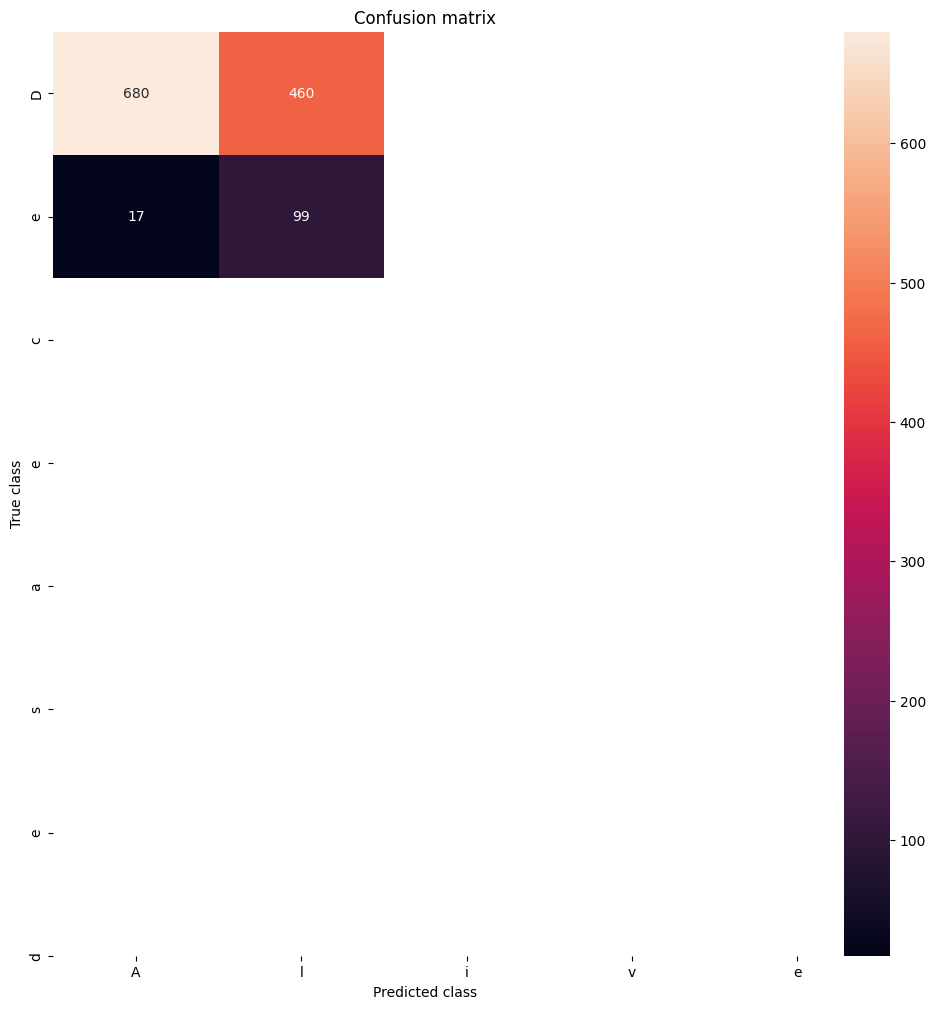

              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74      1140
         1.0       0.18      0.85      0.29       116

    accuracy                           0.62      1256
   macro avg       0.58      0.72      0.52      1256
weighted avg       0.90      0.62      0.70      1256



In [6]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))
pred_y=run_svm_model(X_train_res,X_test,y_train_res,y_test).predict(X_test)
print_results(y_test, pred_y)

# Random Forest Classifier with balanced weights

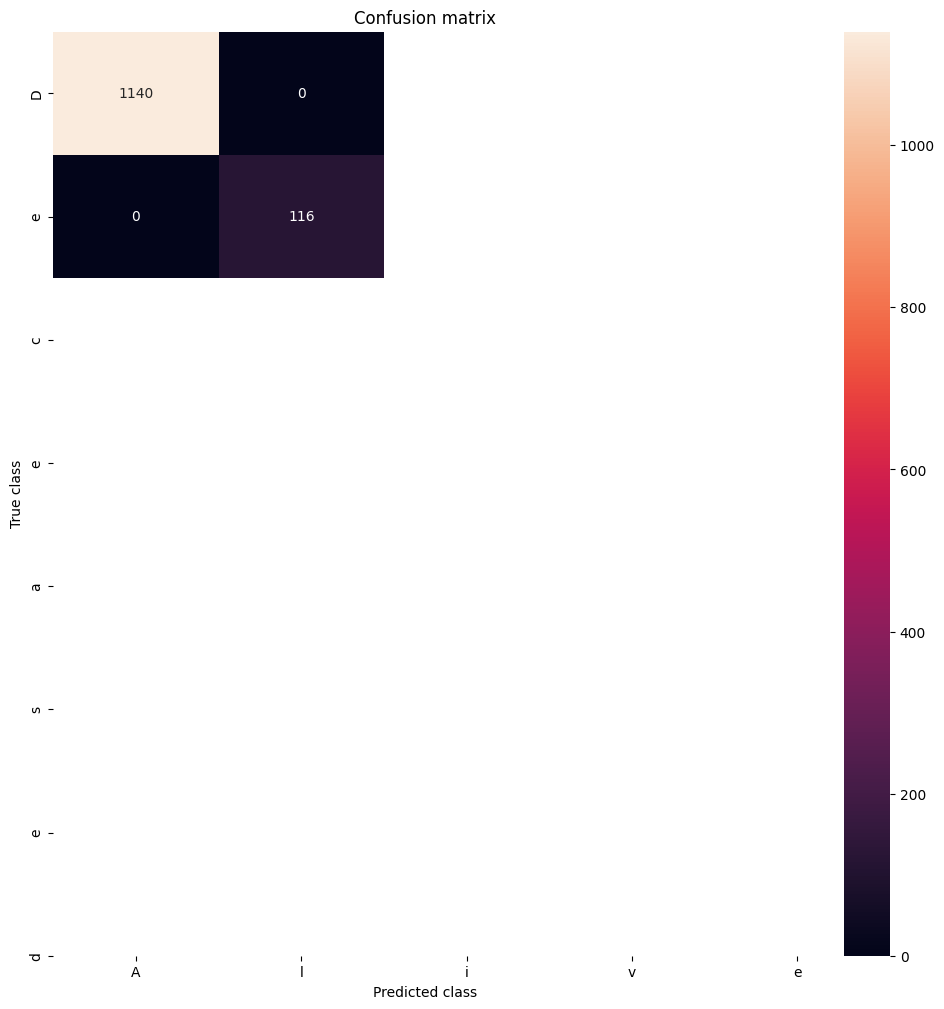

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1140
         1.0       1.00      1.00      1.00       116

    accuracy                           1.00      1256
   macro avg       1.00      1.00      1.00      1256
weighted avg       1.00      1.00      1.00      1256



In [7]:
from sklearn.ensemble import RandomForestClassifier
def run_rf_model(X_train, X_test, y_train, y_test):
    # create a Gaussian Classifier
    rf_clf = RandomForestClassifier(n_estimators=100,random_state=1,class_weight='balanced')

    # train the model using the training sets y_pred=clf.predict(X_test)
    rf_clf.fit(X_train,y_train)
    return rf_clf

pred_y = run_rf_model(X_train,X_test,y_train,y_test).predict(X_test)
print_results(y_test, pred_y)

Distribution before resampling Counter({0.0: 1140, 1.0: 116})
Distribution after resampling Counter({0.0: 116, 1.0: 116})


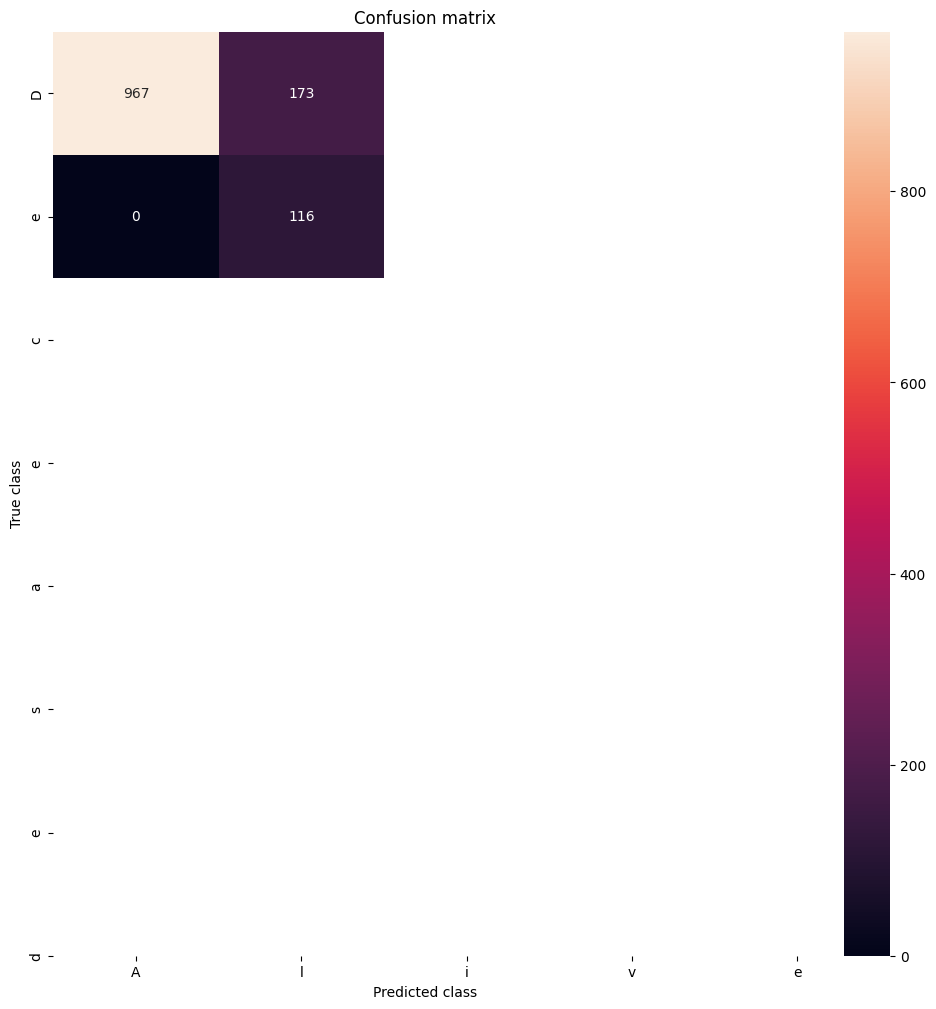

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      1140
         1.0       0.40      1.00      0.57       116

    accuracy                           0.86      1256
   macro avg       0.70      0.92      0.75      1256
weighted avg       0.94      0.86      0.89      1256



In [8]:
# Subsampling
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))
pred_y=run_rf_model(X_train_res,X_test,y_train_res,y_test).predict(X_test)
print_results(y_test, pred_y)